# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions

#import the drive module, which allows users to access files stored in their Google Drive directly from a Colab notebook(Google collab notebook)
from google.colab import drive
from datetime import datetime
from sklearn.metrics import mean_squared_error


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:

#Load your data into a pandas data frame here
# Answer:
#Mount Google Drive to access files stored there
drive.mount('/content/drive')

# Load the dataset from Google Drive into a Pandas DataFrame
# Specify the path to the .txt file and set the delimiter to ';' for correct parsing

file_path = '/content/drive/MyDrive/AAI-530-DataAnalyticsAndIOT/household_power_clean.csv'

# Read the .txt file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify it loaded correctly
print(df.head())

#Check data types of Date and Time columns
print(df.dtypes)

print(df.isna().sum())



Mounted at /content/drive
   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3             Datetime  gap_monthly  \
0         1.00000        17.00000  2006-12-16 17:24:00          NaN   
1         1.00000        16.00000  200

In [4]:
#convert datetime to epoch/unix time

df['unix'] = pd.to_datetime(df['Datetime']).astype(int) // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is the Prediction Horizon. The prediction horizon refers to the number of future time steps for which a model makes predictions. It represents how far into the future the model forecasts. pH depends on the granularity of data (for example 12 months in steps of 1 month or 365 days in steps of 1 day)

mu is the Forgetting Factor. The Forgetting Factor is a parameter used to control how much inportance is given to the past data compared to the new data.It is a value between 0 and 1 where value close to 1 refers to more weight is given to past data.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [5]:
# creates a pandas DataFrame containing only the 'unix' column from DataFrame 'df
ts = pd.DataFrame(df.unix)

#create a pandas DataFrame containing only the 'Global_active_power' column from DataFrame 'df
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes since the data collection is every minuite

#data_resolution = data collectin intervals in minutes
data_resolution = 1

#ph_index refers to how many timestamps is our ph
ph_index = ph // data_resolution
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
#create a numpy array of zeros with length n_s-1 (4999), since n_s = 5000, to store the predicted time values for each step of model
tp_pred = np.zeros(n_s-1)

#reate a numpy array of zeros with length n_s-1(4999), to store the predicted global active power values for each step of model
yp_pred = np.zeros(n_s-1)

print(ts.head())

print(ys.head())

         unix
0  1166289840
1  1166289900
2  1166289960
3  1166290020
4  1166290080
   Global_active_power
0              4.21600
1              5.36000
2              5.37400
3              5.38800
4              3.66600


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: Below is the calculation of the weight of the first data point on the 5000th prediction with a forgetting factor (mu) of 0.9.

The formula for the weight of a data point after n steps is:

$$ w_n = \mu^n $$

Where:
- w_n is the weight after n steps
- μ (mu) is the forgetting factor
- n is the number of steps

In this case:
- μ = 0.9
- n = 4999 (because we're looking at the influence of the 1st point on the 5000th, which is 4999 steps later)

Plugging these values into the formula:

$$ w_{4999} = 0.9^{4999} $$

To calculate this:

1. Take the natural log of both sides:
   $$ \ln(w_{4999}) = 4999 \times \ln(0.9) $$

2. Calculate:
   $$ \ln(w_{4999}) = 4999 \times (-0.10536) = -526.74464 $$

3. Take the exponential of both sides:
   $$ w_{4999} = e^{-526.74464} $$

4. Calculate the final result:
   $$ w_{4999} \approx 1.8126 \times 10^{-229} $$

This extremely small number (0.000...001 with 228 zeros after the decimal point) represents the weight of the first data point on the 5000th prediction.

This means the influence of the first data point is effectively zero by the time we reach the 5000th prediction, demonstrating how the forgetting factor causes the model to prioritize recent data over older observations.

The calculation for the weights of the first 3 data points using a forgetting factor (mu) of 0.9 is as follows:

1. First data point (n = 0):
   Weight = 0.9^0 = 1.0

2. Second data point (n = 1):
   Weight = 0.9^1 = 0.9

3. Third data point (n = 2):
   Weight = 0.9^2 = 0.81

......

5000. Four thousand nine hundred and ninety nine (n = 4999)
      weight = 0.9^4999 = $$ 1.8126 \times 10^{-229} $$

These weights demonstrate how the influence of data points decreases exponentially as they become "older" in the sequence. The first (most recent) data point has full weight, while each subsequent point's weight is reduced by multiplying by the forgetting factor (0.9 in this case).

This weighting scheme allows the model to adapt to recent trends while gradually reducing the impact of older data points, which is particularly useful in time series analysis and adaptive filtering algorithms.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
# code sets up a growing window of data for each iteration. It starts with 2 data points and gradually increases to include all 5000 points.
# This approach is often used in time series analysis and forecasting, where predictions are made based on an increasing amount of historical data (HouseholdPower data)
for i in range(2, n_s+1):# start out with 2 leading datapoints, this loop will run 4999 times (from 2 to 5000)
    #get x and y data "available" for our prediction

    #creates a temporary DataFrame ts_tmp that contains the first i rows of the ts DataFram
    ts_tmp = ts[0:i]

    #creates a temporary DataFrame ys_tmp with the first i rows of the ys DataFrame where ys is the DataFrame containing Target_variable (e.g: power consumption)
    ys_tmp = ys[0:i]

    #assign the length of ys_tmp to the variable ns
    #ns is equal to i in each iteration, representing the number of data points being considered.
    ns = len(ys_tmp)

    #Create an array of length ns (number of samples = 5000) filled with the value of mu
    weights = np.ones(ns)*mu

    for k in range(ns): # iterate over each index in range for ns = 5000
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** k

    #Flip the array so that the most recent data point has the highest weight.
     # For example Before flipping if weights  in ns=5 array is [1, 0.9, 0.81, 0.729, 0.6561],After flipping: it is [0.6561, 0.729, 0.81, 0.9, 1]
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    # creates an instance of the LinearRegression class from scikit-learn LinearRegression
    # which is a simple and widely used statistical method for modeling the relationship between input features and a target variable.
    lm_tmp = LinearRegression()

    #fit the linear regression model to the data
    #arguments:
    # a) ts_tmp: This is the input feature data (X). In this case, the timestamp data.
    # b) ys_tmp: This is the target variable data (y). It's the variable that is being predicted ( power consumption data)
    # c) sample_weight=weights: This is an optional parameter that assigns weights to individual samples, The weights array we calculated earler is used
    #    In this case, more recent data points will have higher weights, making them more influential in determining the model parameters.
    # Output: The linear regression model will be fitted to the data.The model will have learned coefficients (slope) and intercept that best fit the weighted data.
    #          model_tmp will be a fitted model object that can be used for predictions or to extract model parameters.
    model_tmp =lm_tmp.fit(ts_tmp, ys_tmp, sample_weight = weights)

    # store model coefficients and intercepts to compute prediction
    # extract the slope coefficient, coef_ returns an array, for simple LR it is a single element array
    m_tmp = model_tmp.coef_

    # Extract the intercept from the fitted model. The intercept represents the y-value where the regression line crosses the y-axis (i.e., when x = 0).
    # the underscore in intercept_ indicates it's set after fitting.
    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    # This calculates the prediction time by adding the prediction horizon (ph) to the last timestamp in the current data.
    # ts.iloc[ns-1, 0] selects the last timestamp in the current data window.
    # ph is the prediction horizon (how far into the future we're predicting).
    # Adding ph to the last timestamp gives us the future time for which we're making a prediction.
    tp = ts.iloc[ns-1,0] + ph

    # Extract the single element from tp if it's an array
    # Ensure tp is a scalar
    if isinstance(tp, np.ndarray):
     if tp.size > 1:
         tp = tp[0]  # Take the first element if it's an array with multiple elements
     else:
         tp = tp.item()  # Convert single-element array to scalar


    #calculate the predicted power value using the linear equation.
    #  m_tmp * tp is the slope multiplied by the prediction time.
    # Adding q_tmp (the intercept) completes the linear equation: y = mx + b.
    yp = m_tmp * tp + q_tmp

    # Extract the single element from yp if it's an array
    # Ensure tp is a scalar
    if isinstance(yp, np.ndarray):
     if yp.size > 1:
        yp = yp[0]  # Take the first element if it's an array with multiple elements
     else:
        yp = yp.item()  # Convert single-element array to scalar

    # Store the calculated prediction time in the tp_pred array.
    # The index i-2 is used because the loop started at i=2, so we adjust to start filling the array from index 0.
    tp_pred[i-2] = tp

    # Store the predicted y-value in the yp_pred array.
    # i-2 is used to properly index the array.
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

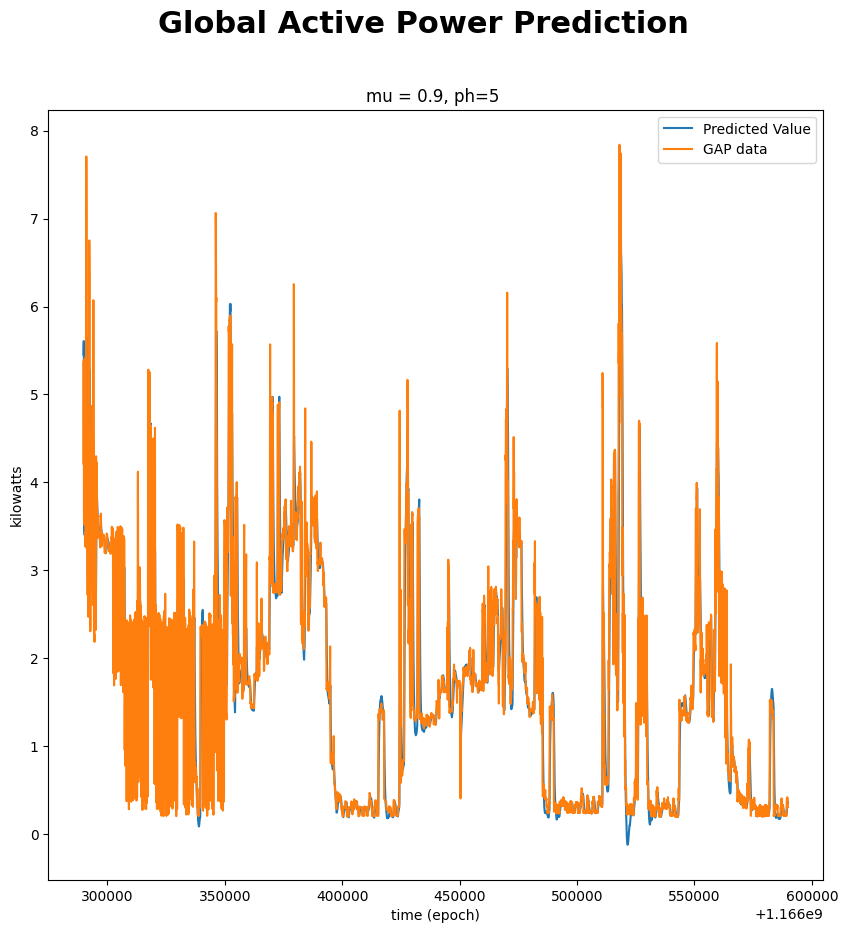

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

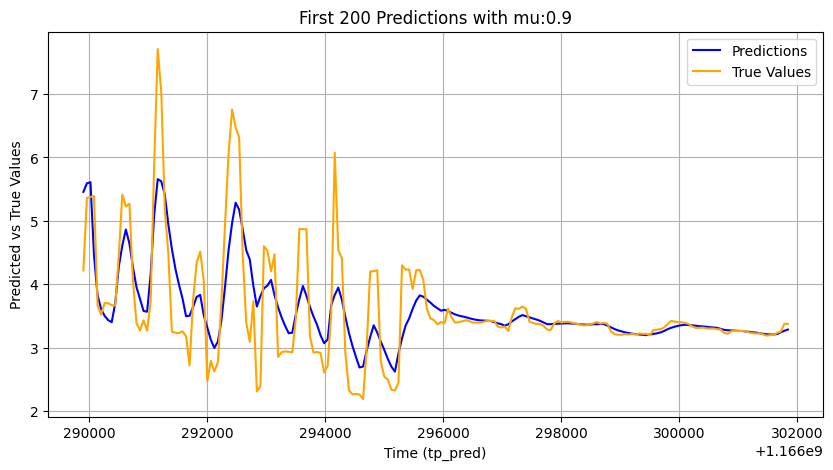

In [8]:
#Plot first 200 data points/predictions
# Visualize the first 200 predictions
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predictions', color='blue')
plt.plot(tp_pred[:200], ys[:200], label='True Values', color='orange')  # True values from ys
plt.title('First 200 Predictions with mu:0.9')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()
plt.show()

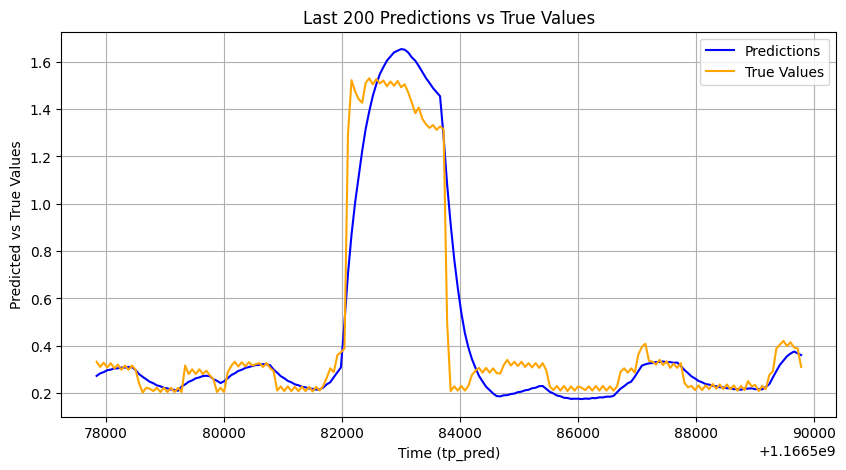

In [9]:
#Plot last 200 data points/predictions
# Ensure we select the corresponding true values for the last 200 predictions
# Calculate the starting index for the last 200 predictions
start_index = len(yp_pred) - 200

# Create a figure for plotting
plt.figure(figsize=(10, 5))

# Plot the last 200 predictions
plt.plot(tp_pred[start_index:], yp_pred[-200:], label='Predictions', color='blue')

# Plot the corresponding true values from ys
plt.plot(tp_pred[start_index:], ys['Global_active_power'].values[start_index:start_index + 200], label='True Values', color='orange')

# Set plot title and labels
plt.title('Last 200 Predictions vs True Values')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [10]:
#Calculate MSE of predictions
print("ph_index is ", ph_index)

ns = len(yp_pred)
print ("Length of ps_prediction = ", ns)

# Function: mean_squared_error(...): This function calculates the mean squared error between the actual values and the predicted values.
# The mean squared error is a measure of the average squared difference between the actual and predicted values. A lower MSE indicates better predictive accuracy.
# argument 1: ys['Global_active_power'][ph_index:5000+ph_index-1]: This subset represents the actual power consumption values that correspond to the predicted values.
# This part selects a subset of the actual values from the ys DataFrame. Specifically, it selects
# the 'Global_active_power' column and takes the values from index ph_index to 5000 + ph_index - 1. The slice [ph_index:5000+ph_index-1] selects the relevant portion of the
# true values that corresponds to the predictions.
#        ph_index: This is the starting point of the slice. It likely represents the prediction horizon index, which is the point from where predictions start.
#        5000: This number represents the number of predictions made. It corresponds to the length of yp_pred.
#        ph_index-1: This is subtracted from 5000+ph_index to ensure that exactly 5000 values are selected.
# argument 2: yp_pred: This is the array of predicted values generated by the model.

mse_value = mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE - mu (0.9) is", mse_value)



ph_index is  5
Length of ps_prediction =  4999
MSE - mu (0.9) is 0.5227914122681482


In [11]:
# Difference between Early and Late Predictions nu= 0.9

# Get the number of rows in ys
row_count = ys.shape[0]
print(f"The number of rows in the DataFrame ys is: {row_count}")

# Get the number of elements in yp_pred
pred_count = len(yp_pred)
print(f"The number of elements in yp_pred is: {pred_count}")

last_200_index = n_s - 200
# Calculate MSE for the first 200 points from the 'Global_active_power' column of the ys DataFrame.
mse_first_200 = mean_squared_error(ys['Global_active_power'][0:+200], yp_pred[:200])

# Calculate MSE for the last 200 point
mse_last_200 = mean_squared_error(ys['Global_active_power'][ph_index+last_200_index:ph_index+n_s], yp_pred[-200:])

print("ph_ind", ph_index)
print("MSE for first 200 points:", mse_first_200)
print("MSE for last 200 points:", mse_last_200)
print("Difference between early and late predictions with mu(0.9):", mse_last_200 - mse_first_200)


The number of rows in the DataFrame ys is: 2049280
The number of elements in yp_pred is: 4999
ph_ind 5
MSE for first 200 points: 0.28544632834348205
MSE for last 200 points: 0.10675399410961622
Difference between early and late predictions with mu(0.9): -0.17869233423386582


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

Answer:
##I. Overall Model Performance:
  ##Model Fit :
 The model appears to capture the general trend and fluctuations in the power consumption data. The predicted values (blue line) follow the true values (orange line) reasonably well, indicating that the model has learned some underlying patterns in the data.

##Variability:
The predictions are more variable than the true values. This indicates that the model might be overfitting to some noise in the data or that there is inherent variability in the power consumption that the model cannot fully account for.

##Local Deviations:
There are instances where the predictions deviate significantly from the true values. This could be due to outliers in the data, sudden changes in power usage patterns that the model hasn't learned to handle, or limitations of the linear regression model itself.

##II. Possible Reasons for Model Performance:

##Data Characteristics:
The nature of household power consumption data can be complex and non-linear. Linear regression might not be the most suitable model for capturing all the nuances in the data.

##Model Limitations:
Linear regression assumes a linear relationship between the input features and the target variable. If the relationship is non-linear, the model might not be able to capture it accurately.

#Data Quality:
The presence of outliers or noise in the data can affect the model's performance.

#III. Difference between Early and Late predictions:
Based on the provided Mean Squared Error (MSE) values, there is indeed a noticeable difference between the early and late predictions:

## MSE for First 200 Points: 0.28544632834348205

This value indicates:
- The model's predictions for the initial 200 points have a moderate level of error.
- There is some discrepancy between the predicted and actual values in the early stages of the forecast.

## MSE for Last 200 Points: 0.10675399410961622

This lower MSE suggests:
- The model's performance improves significantly for the last 200 points.
- Predictions for later data points are more accurate compared to the early predictions.

## Difference: -0.17869233423386582

The negative difference (early MSE minus late MSE) indicates:
- A substantial improvement in prediction accuracy over time.
- The model's performance is better for later predictions compared to earlier ones.

## Analysis for μ = 0.9

With μ (mu) set to 0.9:
- Recent data points are given more weight in the prediction model.
- This weighting scheme appears to be effective, as evidenced by the improved accuracy for later predictions.
- The model adapts well to the data patterns over time, resulting in better performance for more recent predictions.

The significant improvement in prediction accuracy from early to late points (about 62.6% reduction in MSE) suggests that:
1. The model becomes more effective at capturing underlying patterns in the data as it processes more information.
2. The chosen μ value of 0.9 allows the model to adapt well to changing trends while still considering historical data.
3. The prediction horizon and data characteristics likely align well with this forgetting factor, enabling improved forecasting as more data becomes available.

In conclusion, there is a clear difference between early and late predictions, with the model demonstrating substantially better performance in its later predictions. This improvement indicates that the chosen approach with μ = 0.9 is effective for this particular time series forecasting task.

#IV. Improvements to Enhance model performance:
#Consideration of Non-linear Models:
Exploration of models like decision trees, support vector machines, or neural networks that can capture non-linear relationships is needed.

#Feature Engineering:
Create additional features that might be relevant for predicting power consumption, such as during peak hour time of day, power consumption during day of the week(example on sundays), weather conditions, etc.

#Data Preprocessing:
Clean the data by removing outliers

##V. MEAN SQUARED ERROR:
Mean Squared Error is defined as the average of the squared differences between the predicted values and the actual values:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

Where:
- $$n$$ is the number of data points
- $$y_i$$ is the actual value for the $$i$$-th data point
- $$\hat{y}_i$$ is the predicted value for the $$i$$-th data point

### Interpretation

1. **Perfect Prediction**:
   $$ \text{MSE} = 0 \implies y_i = \hat{y}_i \quad \forall i $$

2. **Positive Values**:
   $$ \text{MSE} \geq 0 $$

3. **Scale Dependency**:
   MSE is dependent on the scale of $$y$$. It has the same unit as the square of the original variable.

4. **Error Magnitude**:
   For a given MSE value $$k$$:
   $$ \text{MSE} = k \implies \text{Average Error} \approx \sqrt{k} $$

### Example Interpretation

Given MSE = 0.52:

$$
\sqrt{0.52} \approx 0.72
$$

This indicates that, on average, predictions deviate from actual values by approximately 0.72 units in the original scale of measurement.

### Comparative Interpretation

For models A and B with respective MSEs:

$$
\text{MSE}_A < \text{MSE}_B \implies \text{Model A performs better than Model B}
$$

$$
\text{MSE}_A > \text{MSE}_B \implies \text{Model B performs better than Model A}
$$

The lower the MSE, the better the model's predictive performance.

The Mean Squared Error (MSE) of 0.52 indicates the average squared difference between the predicted values and the true values. A lower MSE generally means better model performance. In this case, an MSE of 0.52 suggests that, on average, the squared error between the predictions and the true values is 0.52.


**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [12]:
#Prediction code with mu = 1.0
# creates a pandas DataFrame containing only the 'unix' column from DataFrame 'df
ts = pd.DataFrame(df.unix)

#create a pandas DataFrame containing only the 'Global_active_power' column from DataFrame 'df
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes since the data collection is every minuite

#data_resolution = data collectin intervals in minutes
data_resolution = 1

#ph_index refers to how many timestamps is our ph
ph_index = ph // data_resolution
mu = 1.0

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
#create a numpy array of zeros with length n_s-1 (4999), since n_s = 5000, to store the predicted time values for each step of model
tp_pred = np.zeros(n_s-1)

#reate a numpy array of zeros with length n_s-1(4999), to store the predicted global active power values for each step of model
yp_pred = np.zeros(n_s-1)

print(ts.head())

print(ys.head())

# At every iteration of the for loop a new data sample is acquired
# code sets up a growing window of data for each iteration. It starts with 2 data points and gradually increases to include all 5000 points.
# This approach is often used in time series analysis and forecasting, where predictions are made based on an increasing amount of historical data (HouseholdPower data)
for i in range(2, n_s+1):# start out with 2 leading datapoints, this loop will run 4999 times (from 2 to 5000)
    #get x and y data "available" for our prediction

    #creates a temporary DataFrame ts_tmp that contains the first i rows of the ts DataFram
    ts_tmp = ts[0:i]

    #creates a temporary DataFrame ys_tmp with the first i rows of the ys DataFrame where ys is the DataFrame containing Target_variable (e.g: power consumption)
    ys_tmp = ys[0:i]

    #assign the length of ys_tmp to the variable ns
    #ns is equal to i in each iteration, representing the number of data points being considered.
    ns = len(ys_tmp)

    #Create an array of length ns (number of samples = 5000) filled with the value of mu
    weights = np.ones(ns)*mu

    for k in range(ns): # iterate over each index in range for ns = 5000
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** k

    #Flip the array so that the most recent data point has the highest weight.
     # For example Before flipping if weights  in ns=5 array is [1, 0.9, 0.81, 0.729, 0.6561],After flipping: it is [0.6561, 0.729, 0.81, 0.9, 1]
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    # creates an instance of the LinearRegression class from scikit-learn LinearRegression
    # which is a simple and widely used statistical method for modeling the relationship between input features and a target variable.
    lm_tmp = LinearRegression()

    #fit the linear regression model to the data
    #arguments:
    # a) ts_tmp: This is the input feature data (X). In this case, the timestamp data.
    # b) ys_tmp: This is the target variable data (y). It's the variable that is being predicted ( power consumption data)
    # c) sample_weight=weights: This is an optional parameter that assigns weights to individual samples, The weights array we calculated earler is used
    #    In this case, more recent data points will have higher weights, making them more influential in determining the model parameters.
    # Output: The linear regression model will be fitted to the data.The model will have learned coefficients (slope) and intercept that best fit the weighted data.
    #          model_tmp will be a fitted model object that can be used for predictions or to extract model parameters.
    model_tmp =lm_tmp.fit(ts_tmp, ys_tmp, sample_weight = weights)

    # store model coefficients and intercepts to compute prediction
    # extract the slope coefficient, coef_ returns an array, for simple LR it is a single element array
    m_tmp = model_tmp.coef_

    # Extract the intercept from the fitted model. The intercept represents the y-value where the regression line crosses the y-axis (i.e., when x = 0).
    # the underscore in intercept_ indicates it's set after fitting.
    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    # This calculates the prediction time by adding the prediction horizon (ph) to the last timestamp in the current data.
    # ts.iloc[ns-1, 0] selects the last timestamp in the current data window.
    # ph is the prediction horizon (how far into the future we're predicting).
    # Adding ph to the last timestamp gives us the future time for which we're making a prediction.
    tp = ts.iloc[ns-1,0] + ph

    # Extract the single element from tp if it's an array
    # Ensure tp is a scalar
    if isinstance(tp, np.ndarray):
     if tp.size > 1:
         tp = tp[0]  # Take the first element if it's an array with multiple elements
     else:
         tp = tp.item()  # Convert single-element array to scalar


    #calculate the predicted power value using the linear equation.
    #  m_tmp * tp is the slope multiplied by the prediction time.
    # Adding q_tmp (the intercept) completes the linear equation: y = mx + b.
    yp = m_tmp * tp + q_tmp

    # Extract the single element from yp if it's an array
    # Ensure tp is a scalar
    if isinstance(yp, np.ndarray):
     if yp.size > 1:
        yp = yp[0]  # Take the first element if it's an array with multiple elements
     else:
        yp = yp.item()  # Convert single-element array to scalar

    # Store the calculated prediction time in the tp_pred array.
    # The index i-2 is used because the loop started at i=2, so we adjust to start filling the array from index 0.
    tp_pred[i-2] = tp

    # Store the predicted y-value in the yp_pred array.
    # i-2 is used to properly index the array.
    yp_pred[i-2] = yp

         unix
0  1166289840
1  1166289900
2  1166289960
3  1166290020
4  1166290080
   Global_active_power
0              4.21600
1              5.36000
2              5.37400
3              5.38800
4              3.66600


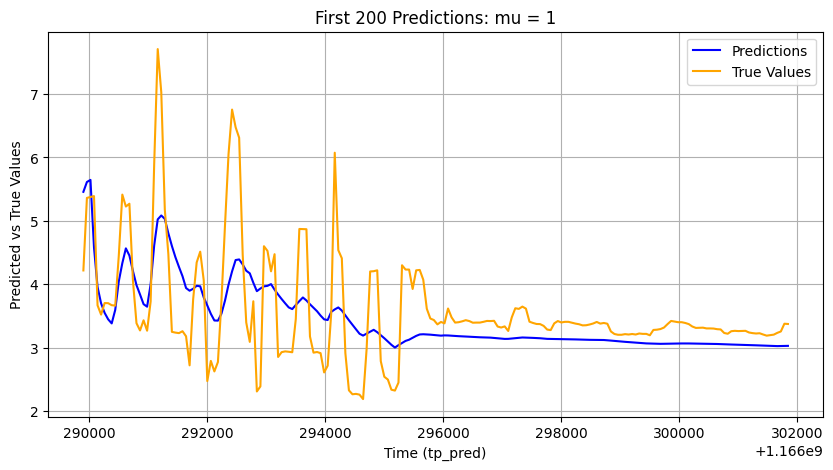

In [13]:
#Plot first 200 data points/predictions for mu = 1
# Visualize the first 200 predictions
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predictions', color='blue')
plt.plot(tp_pred[:200], ys[:200], label='True Values', color='orange')  # True values from ys
plt.title('First 200 Predictions: mu = 1')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()
plt.show()

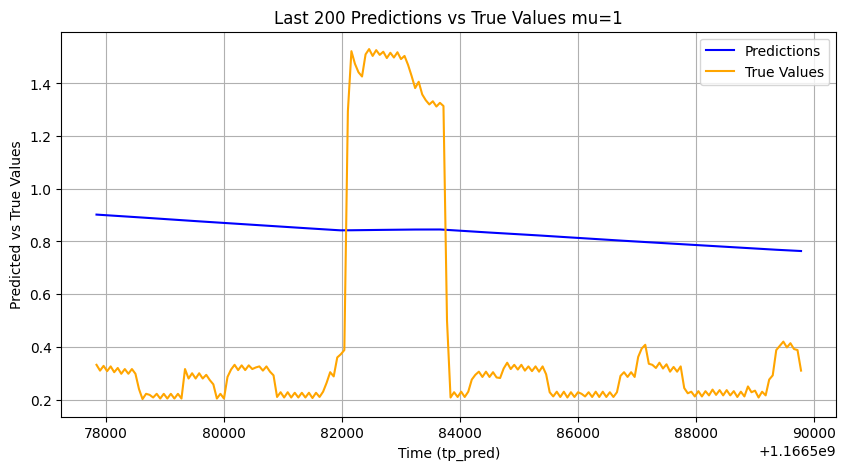

ph_index is  5
Length of ps_prediction =  4999
MSE is 1.4172641534431423


In [14]:
#Plot last 200 data points/predictions for mu = 1

# Ensure we select the corresponding true values for the last 200 predictions
# Calculate the starting index for the last 200 predictions
start_index = len(yp_pred) - 200

# Create a figure for plotting
plt.figure(figsize=(10, 5))

# Plot the last 200 predictions
plt.plot(tp_pred[start_index:], yp_pred[-200:], label='Predictions', color='blue')

# Plot the corresponding true values from ys
plt.plot(tp_pred[start_index:], ys['Global_active_power'].values[start_index:start_index + 200], label='True Values', color='orange')

# Set plot title and labels
plt.title('Last 200 Predictions vs True Values mu=1')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()

#Calculate MSE of predictions
print("ph_index is ", ph_index)

ns = len(yp_pred)
print ("Length of ps_prediction = ", ns)

# Function: mean_squared_error(...): This function calculates the mean squared error between the actual values and the predicted values.
# The mean squared error is a measure of the average squared difference between the actual and predicted values. A lower MSE indicates better predictive accuracy.
# argument 1: ys['Global_active_power'][ph_index:5000+ph_index-1]: This subset represents the actual power consumption values that correspond to the predicted values.
# This part selects a subset of the actual values from the ys DataFrame. Specifically, it selects
# the 'Global_active_power' column and takes the values from index ph_index to 5000 + ph_index - 1. The slice [ph_index:5000+ph_index-1] selects the relevant portion of the
# true values that corresponds to the predictions.
#        ph_index: This is the starting point of the slice. It likely represents the prediction horizon index, which is the point from where predictions start.
#        5000: This number represents the number of predictions made. It corresponds to the length of yp_pred.
#        ph_index-1: This is subtracted from 5000+ph_index to ensure that exactly 5000 values are selected.
# argument 2: yp_pred: This is the array of predicted values generated by the model.

mse_value = mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE is", mse_value)

In [15]:
# Difference between Early and Late Predictions, mu=1.0.
# Calculate MSE for the first 200 points
mse_first_200 = mean_squared_error(ys['Global_active_power'][ph_index:ph_index+200], yp_pred[:200])

# Calculate MSE for the last 200 points
mse_last_200 = mean_squared_error(ys['Global_active_power'][ph_index+4800:ph_index+5000], yp_pred[-200:])

print("MSE for first 200 points:", mse_first_200)
print("MSE for last 200 points:", mse_last_200)
print("Difference between early and late predictions with mu(1.0):", mse_last_200 - mse_first_200)

MSE for first 200 points: 0.925728818170541
MSE for last 200 points: 0.3215458172674538
Difference between early and late predictions with mu(1.0): -0.6041830009030872


In [16]:
#Calculate MSE of predictions for mu = 1

ns = len(yp_pred)
print ("Length of ps_prediction = ", ns)

# Function: mean_squared_error(...): This function calculates the mean squared error between the actual values and the predicted values.
# The mean squared error is a measure of the average squared difference between the actual and predicted values. A lower MSE indicates better predictive accuracy.
# argument 1: ys['Global_active_power'][ph_index:5000+ph_index-1]: This subset represents the actual power consumption values that correspond to the predicted values.
# This part selects a subset of the actual values from the ys DataFrame. Specifically, it selects
# the 'Global_active_power' column and takes the values from index ph_index to 5000 + ph_index - 1. The slice [ph_index:5000+ph_index-1] selects the relevant portion of the
# true values that corresponds to the predictions.
#        ph_index: This is the starting point of the slice. It likely represents the prediction horizon index, which is the point from where predictions start.
#        5000: This number represents the number of predictions made. It corresponds to the length of yp_pred.
#        ph_index-1: This is subtracted from 5000+ph_index to ensure that exactly 5000 values are selected.
# argument 2: yp_pred: This is the array of predicted values generated by the model.

mse_value = mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE, mu(1.0)", mse_value)

Length of ps_prediction =  4999
MSE, mu(1.0) 1.4172641534431423


In [17]:
#Re-run prediction code for mu = 0.01
# creates a pandas DataFrame containing only the 'unix' column from DataFrame 'df
ts = pd.DataFrame(df.unix)

#create a pandas DataFrame containing only the 'Global_active_power' column from DataFrame 'df
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes since the data collection is every minuite

#data_resolution = data collectin intervals in minutes
data_resolution = 1

#ph_index refers to how many timestamps is our ph
ph_index = ph // data_resolution
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
#create a numpy array of zeros with length n_s-1 (4999), since n_s = 5000, to store the predicted time values for each step of model
tp_pred = np.zeros(n_s-1)

#reate a numpy array of zeros with length n_s-1(4999), to store the predicted global active power values for each step of model
yp_pred = np.zeros(n_s-1)

print(ts.head())

print(ys.head())

# At every iteration of the for loop a new data sample is acquired
# code sets up a growing window of data for each iteration. It starts with 2 data points and gradually increases to include all 5000 points.
# This approach is often used in time series analysis and forecasting, where predictions are made based on an increasing amount of historical data (HouseholdPower data)
for i in range(2, n_s+1):# start out with 2 leading datapoints, this loop will run 4999 times (from 2 to 5000)
    #get x and y data "available" for our prediction

    #creates a temporary DataFrame ts_tmp that contains the first i rows of the ts DataFram
    ts_tmp = ts[0:i]

    #creates a temporary DataFrame ys_tmp with the first i rows of the ys DataFrame where ys is the DataFrame containing Target_variable (e.g: power consumption)
    ys_tmp = ys[0:i]

    #assign the length of ys_tmp to the variable ns
    #ns is equal to i in each iteration, representing the number of data points being considered.
    ns = len(ys_tmp)

    #Create an array of length ns (number of samples = 5000) filled with the value of mu
    weights = np.ones(ns)*mu

    for k in range(ns): # iterate over each index in range for ns = 5000
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** k

    #Flip the array so that the most recent data point has the highest weight.
     # For example Before flipping if weights  in ns=5 array is [1, 0.9, 0.81, 0.729, 0.6561],After flipping: it is [0.6561, 0.729, 0.81, 0.9, 1]
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    # creates an instance of the LinearRegression class from scikit-learn LinearRegression
    # which is a simple and widely used statistical method for modeling the relationship between input features and a target variable.
    lm_tmp = LinearRegression()

    #fit the linear regression model to the data
    #arguments:
    # a) ts_tmp: This is the input feature data (X). In this case, the timestamp data.
    # b) ys_tmp: This is the target variable data (y). It's the variable that is being predicted ( power consumption data)
    # c) sample_weight=weights: This is an optional parameter that assigns weights to individual samples, The weights array we calculated earler is used
    #    In this case, more recent data points will have higher weights, making them more influential in determining the model parameters.
    # Output: The linear regression model will be fitted to the data.The model will have learned coefficients (slope) and intercept that best fit the weighted data.
    #          model_tmp will be a fitted model object that can be used for predictions or to extract model parameters.
    model_tmp =lm_tmp.fit(ts_tmp, ys_tmp, sample_weight = weights)

    # store model coefficients and intercepts to compute prediction
    # extract the slope coefficient, coef_ returns an array, for simple LR it is a single element array
    m_tmp = model_tmp.coef_

    # Extract the intercept from the fitted model. The intercept represents the y-value where the regression line crosses the y-axis (i.e., when x = 0).
    # the underscore in intercept_ indicates it's set after fitting.
    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    # This calculates the prediction time by adding the prediction horizon (ph) to the last timestamp in the current data.
    # ts.iloc[ns-1, 0] selects the last timestamp in the current data window.
    # ph is the prediction horizon (how far into the future we're predicting).
    # Adding ph to the last timestamp gives us the future time for which we're making a prediction.
    tp = ts.iloc[ns-1,0] + ph

    # Extract the single element from tp if it's an array
    # Ensure tp is a scalar
    if isinstance(tp, np.ndarray):
     if tp.size > 1:
         tp = tp[0]  # Take the first element if it's an array with multiple elements
     else:
         tp = tp.item()  # Convert single-element array to scalar


    #calculate the predicted power value using the linear equation.
    #  m_tmp * tp is the slope multiplied by the prediction time.
    # Adding q_tmp (the intercept) completes the linear equation: y = mx + b.
    yp = m_tmp * tp + q_tmp

    # Extract the single element from yp if it's an array
    # Ensure tp is a scalar
    if isinstance(yp, np.ndarray):
     if yp.size > 1:
        yp = yp[0]  # Take the first element if it's an array with multiple elements
     else:
        yp = yp.item()  # Convert single-element array to scalar

    # Store the calculated prediction time in the tp_pred array.
    # The index i-2 is used because the loop started at i=2, so we adjust to start filling the array from index 0.
    tp_pred[i-2] = tp

    # Store the predicted y-value in the yp_pred array.
    # i-2 is used to properly index the array.
    yp_pred[i-2] = yp

         unix
0  1166289840
1  1166289900
2  1166289960
3  1166290020
4  1166290080
   Global_active_power
0              4.21600
1              5.36000
2              5.37400
3              5.38800
4              3.66600


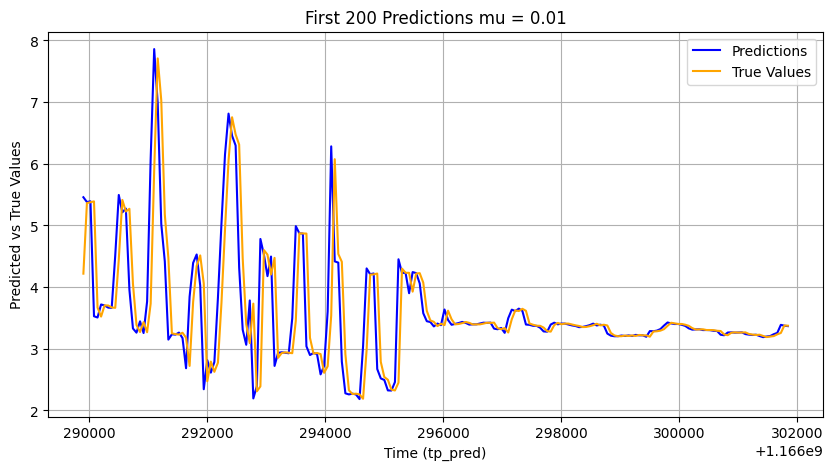

In [18]:
#Plot first 200 data points/predictions for mu = 0.01
# Visualize the first 200 predictions
plt.figure(figsize=(10, 5))
plt.plot(tp_pred[:200], yp_pred[:200], label='Predictions', color='blue')
plt.plot(tp_pred[:200], ys[:200], label='True Values', color='orange')  # True values from ys
plt.title('First 200 Predictions mu = 0.01')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()
plt.show()

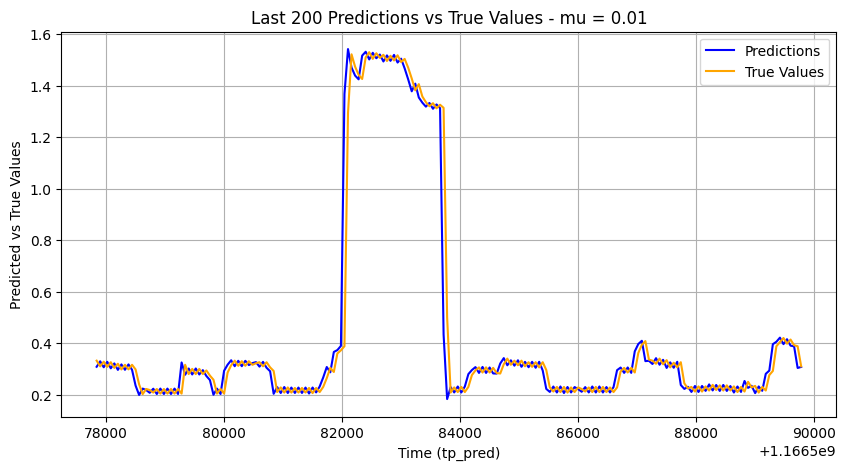

In [19]:
#Plot last 200 data points/predictions for mu = 0.01

# Ensure we select the corresponding true values for the last 200 predictions
# Calculate the starting index for the last 200 predictions
start_index = len(yp_pred) - 200

# Create a figure for plotting
plt.figure(figsize=(10, 5))

# Plot the last 200 predictions
plt.plot(tp_pred[start_index:], yp_pred[-200:], label='Predictions', color='blue')

# Plot the corresponding true values from ys
plt.plot(tp_pred[start_index:], ys['Global_active_power'].values[start_index:start_index + 200], label='True Values', color='orange')

# Set plot title and labels
plt.title('Last 200 Predictions vs True Values - mu = 0.01')
plt.xlabel('Time (tp_pred)')
plt.ylabel('Predicted vs True Values')
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [20]:
#Calculate MSE of predictions for mu = 0.01
#Calculate MSE of predictions for mu = 1
#print("ph_index is ", ph_index)

ns = len(yp_pred)
print ("Length of ps_prediction = ", ns)

# Function: mean_squared_error(...): This function calculates the mean squared error between the actual values and the predicted values.
# The mean squared error is a measure of the average squared difference between the actual and predicted values. A lower MSE indicates better predictive accuracy.
# argument 1: ys['Global_active_power'][ph_index:5000+ph_index-1]: This subset represents the actual power consumption values that correspond to the predicted values.
# This part selects a subset of the actual values from the ys DataFrame. Specifically, it selects
# the 'Global_active_power' column and takes the values from index ph_index to 5000 + ph_index - 1. The slice [ph_index:5000+ph_index-1] selects the relevant portion of the
# true values that corresponds to the predictions.
#        ph_index: This is the starting point of the slice. It likely represents the prediction horizon index, which is the point from where predictions start.
#        5000: This number represents the number of predictions made. It corresponds to the length of yp_pred.
#        ph_index-1: This is subtracted from 5000+ph_index to ensure that exactly 5000 values are selected.
# argument 2: yp_pred: This is the array of predicted values generated by the model.

mse_value = mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1], yp_pred)
print("MSE with mu(0.01) is", mse_value)

Length of ps_prediction =  4999
MSE with mu(0.01) is 0.595453046933643


In [21]:
# Difference between Early and Late Predictions nu= 0.01

# Calculate MSE for the first 200 points
mse_first_200 = mean_squared_error(ys['Global_active_power'][ph_index:ph_index+200], yp_pred[:200])

# Calculate MSE for the last 200 points
mse_last_200 = mean_squared_error(ys['Global_active_power'][ph_index+4800:ph_index+n_s], yp_pred[-200:])

print("MSE for first 200 points:", mse_first_200)
print("MSE for last 200 points:", mse_last_200)
print("Difference between early and late predictions with mu(0.01):", mse_last_200 - mse_first_200)



MSE for first 200 points: 1.6724225232321919
MSE for last 200 points: 0.061636546682227504
Difference between early and late predictions with mu(0.01): -1.6107859765499644


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The following are the details of Model performance with mu =1
## I. MODEL PERFORMANCE WITH mu = 1
##Overall Fit:
The model appears to have a poor fit to the data. The predicted values (blue line) are almost flat, indicating that the model is not capturing the fluctuations in the power consumption data.

##High Bias:
The predictions are consistently lower than the true values, suggesting a high bias in the model.

##II. Reasons for Poor Performance:

##Equal Weighting of Past Data:
Setting mu = 1.0 gives equal weight to all past data points, which is not ideal for time series data where recent data is usually more relevant than older data.

##Lack of Sensitivity:
The model is not capturing the  fluctuations in the data, leading to poor predictions.


##III. Difference between Early and late Predictions:

Based on the provided Mean Squared Error (MSE) values, there is indeed a significant difference between the early and late predictions:

## MSE for First 200 Points: 0.925728818170541

This relatively high MSE indicates:
- The model's predictions for the initial 200 points have a moderate level of error.
- There is a notable discrepancy between predicted and actual values in the early stages of the forecast.
- The model may be struggling to capture early patterns or trends in the data.

## MSE for Last 200 Points: 0.3215458172674538

This lower MSE suggests:
- The model's performance improves substantially for the last 200 points.
- Predictions for later data points are considerably more accurate.
- The model has likely learned and adapted to the underlying patterns in the data over time.

## Difference: -0.6041830009030872

The negative difference (early MSE minus late MSE) indicates:
- A significant improvement in prediction accuracy over time.
- The model's performance is markedly better for later predictions compared to earlier ones.

## Analysis for μ = 1.0

- All historical data points are given equal weight in the prediction model.
- Despite equal weighting, the model shows a substantial improvement in accuracy over time.
- This suggests that the accumulation of more data points helps refine the model's predictions, even without emphasizing recent data.

The considerable improvement in prediction accuracy from early to late points (about 65.3% reduction in MSE) indicates that:
1. The model becomes much more effective at capturing the underlying patterns in the data as it processes more information.
2. The initial predictions may be less reliable due to limited historical data.
3. The equal weighting of historical data (μ = 1.0) allows the model to build a more comprehensive understanding of the time series as more data becomes available.

##V. Interpretation of MSE = 1.417 (with mu = 1.0 )

#### Error Magnitude:
An MSE of 1.417 suggests that, on average, the squared errors between the actual and predicted values are larger compared to an MSE of 0.52 (with $$ \mu = 0.9 $$). This means the predictions are less accurate when $$ \mu = 1.0 $$.

#### Model Performance:
The higher MSE indicates that the model's predictions are further from the actual values, implying that the model is not performing as well as it could be.

### Impact of mu = 1.0:

#### Weighting Factor:
The parameter mu adjusts the weights of the data points based on their timesteps. When mu = 1.0 all data points are given equal weight, regardless of their distance from the prediction point.

#### Effect on Predictions:
With equal weighting, the model does not prioritize more recent data points, which might be more relevant for making accurate predictions in time series analysis. This can lead to less accurate predictions and a higher MSE.

### Practical Implications

#### Model Adjustment:
The higher MSE with mu = 1.0 suggests that the model might benefit from adjusting the weighting factor mu. Using a value of mu < 1.0 (e.g., mu = 0.9) gives more weight to recent data points, which can improve the model's accuracy.

#### Model Evaluation:
 A lower MSE with mu = 0.9 (MSE = 0.52) indicates that giving more weight to recent data points improves predictions.

### Summary

An MSE of 1.417 with mu = 1.0 indicates that the model's predictions are less accurate compared to when mu = 0.9. Adjusting mu to prioritize recent data improves performance, as evidenced by a lower MSE with mu = 0.9.


**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The following are the model performance overview with mu = 0.01
## I. Model Performance Overview with mu = 0.01

### Accuracy and Pattern Recognition
The model demonstrates a reasonable ability to capture the overall trends in power consumption. The predicted values generally align with the actual data, suggesting the model has grasped some fundamental patterns.

### Prediction Volatility
There's noticeable fluctuation in the model's predictions, exceeding that of the actual data. This could indicate the model is either overly sensitive to minor data variations or struggling to fully comprehend the complexities of power usage patterns.

### Inconsistent Precision
At times, the model's predictions diverge  from real values. These discrepancies might arise from unexpected power usage events, data anomalies, or the inherent limitations of linear regression in capturing complex relationships.

## Factors Influencing Model Behavior

### Data Complexity
Household power consumption data often involves intricate, non-linear patterns. The linear regression approach may be too simplistic to fully capture these nuances.

### Model Constraints
The linear regression framework assumes straightforward, linear relationships between variables. This assumption may not hold true for the multifaceted nature of power consumption data.

### Data Integrity
The model's performance could be affected by data quality issues such as outliers or inconsistencies in the dataset.

### Temporal Dynamics
Power consumption patterns can vary significantly over time due to factors like seasonal changes or lifestyle shifts. The model may struggle to adapt to these temporal variations.

### Feature Limitations
The predictive power of the model is constrained by the input features provided. Important factors influencing power consumption might be missing from the dataset.

##II. Difference between Early and Late predictions:
Yes, there is a significant difference between the early and late predictions, as evidenced by the MSE values:

## Early Predictions (First 200 points)
MSE = 1.6724225232321919
- The high MSE indicates poor prediction accuracy in the early stages
- The model struggles to make accurate predictions with limited initial data
- There is substantial deviation between predicted and actual values

## Late Predictions (Last 200 points)
MSE = 0.061636546682227504
- The dramatically lower MSE shows much better prediction accuracy
- The model performs significantly better after learning from more data
- Predictions align much more closely with actual values

## Analysis of Difference (-1.6107859765499644)
- The large negative difference (early MSE minus late MSE) indicates a dramatic improvement in prediction accuracy over time
- The model's error reduces by approximately 96.3% from early to late predictions
- With μ = 0.01, the model heavily weights recent data, which appears to be very effective for later predictions

This substantial improvement in prediction accuracy suggests that:
1. The model needs time to learn the underlying patterns in the data
2. The very low μ value (0.01) allows the model to adapt quickly to recent patterns
3. The initial predictions are less reliable due to limited historical data and the model's learning phase

In conclusion, there is a clear and substantial difference between early and late predictions, with the model performing remarkably better in its later predictions.

##III. Interpretation of MSE = 0.595453046933643
When the Mean Squared Error (MSE) is 0.595453046933643, the following are the model performance.

### Error Magnitude
- The MSE value represents the average squared difference between predicted and actual values
- A value of approximately 0.60 indicates moderate prediction accuracy
- The square root of this MSE (√0.595 ≈ 0.771) gives the root mean square error, representing the average deviation in the original units

### Model Performance Indicators
1. **Accuracy Level**:
   - The model shows reasonable but not perfect accuracy
   - Predictions deviate from actual values by about 0.77 units on average
   - This suggests moderate predictive power

2. **Relative Performance**:
   - Better than models with MSE > 1.0
   - Room for improvement compared to models with MSE closer to 0
   - Indicates a balance between model complexity and accuracy

### Practical Implications
1. **Prediction Reliability**:
   - Predictions are generally reliable but with some margin of error
   - Suitable for applications where moderate accuracy is acceptable
   - May need refinement for applications requiring higher precision

2. **Model Evaluation**:
   - The model captures significant patterns in the data
   - There's still unexplained variance in the predictions
   - Could potentially be improved through model adjustments or additional features

This MSE value suggests that while the model is performing adequately, there might be room for improvement depending on the specific requirements of the application.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A:
Based on the MSE values for different μ parameters:

μ = 0.9: MSE = 0.52
μ = 1.0: MSE = 1.417
μ = 0.01: MSE = 0.599

The model with μ = 0.9 performs best for the following reasons:

1. **Lowest MSE**:
- MSE of 0.52 indicates the smallest average squared difference between predictions and actual values
- This represents a 63% improvement over μ = 1.0 and 13% improvement over μ = 0.01

2. **Optimal Balance**:
- μ = 0.9 provides the right balance between historical and recent data
- Recent observations get slightly more weight but historical patterns aren't ignored
- This balancing helps capture both long-term trends and recent changes

3. **The reason for the model with μ = 0.9 is good model**:
- μ = 1.0 gives equal weight to all historical data, making the model too rigid
- μ = 0.01 almost completely discards historical data, making it too reactive
- μ = 0.9 creates an exponential decay that maintains meaningful influence from recent history while still considering longer-term patterns

This demonstrates that for this power consumption data, maintaining a strong but not exclusive focus on recent data (μ = 0.9) produces the most accurate predictions.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: The following are the improvements that could be done to the model.

#Feature Engineering:
Creation of additional features that might be relevant for predicting power consumption, such as during peak hour time of day, power consumption during day of the week(example on sundays) and weather conditions in the model

##Regularization
Regularization Techniques: Regularization techniques like Lasso (L1) or Ridge (L2) regression can be applied to prevent overfitting and improve model generalization.

#Model Interpretation
Explainability: Usage of techniques like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to interpret the model's predictions and understand the impact of different features can be done.

##Model Enhancements
Addition of support for multiple features beyond just timestamps by understanding the domain can be done.
Inclusion of confidence intervals for predictions
Develop ensemble methods combining predictions from multiple models

#Consideration of Non-linear Models:
#Model Complexity
Advanced Models: Consierations can be given to use complex models like decision trees, support vector machines, ARIMA, SARIMA, or machine learning models such as Random Forest, Gradient Boosting, or Neural Networks(e.g., Recurrent Neural Networks (RNNs) like LSTMs, Variational mode decomposition). These models can capture more complex non-linear patterns in the data. Also Techniques like rolling window forecasting, more frequent model updates would be good.
The Time Series Specific Models: Investigate models designed for time series data, such asAutoregressive Integrated Moving Average (ARIMA) and Exponential Smoothing for the Household Power consumption type of data.

##Architectural Improvements
Implementation of a sliding window approach instead of growing window can be done. Additon of periodic model retraining capabilities can be done. Also inclusion of online learning capabilities for real-time updates would be good.

#Hyperparameter Tuning - Grid Search/Random Search:
Search for the best hyperparameter values (e.g., regularization parameters for SVR, number of trees for Random Forests) using techniques like grid search or random search can be done.

##Ensemble Methods:
Combine multiple models to create an ensemble model, which can improve prediction accuracy by leveraging the strengths of different models.


##Evaluation Metrics
Multiple Metrics: Evaluation of model using multiple metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared can be done. Implementation of k-fold cross-validation can be done. This provides a more comprehensive understanding of model performance.


##Cross-Validation:
Cross-validation is a good technique to assess the model's performance on different subsets of the data, ensuring that the model generalizes well to unseen data.


**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [22]:
#create your alternative training data here
# Prepare the data
ts = pd.DataFrame({'Time': df.unix, 'Voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5  # 5 minutes
ph_index = ph
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)


In [23]:
#re-run the prediction code here
# Prepare the data
ts = pd.DataFrame({'Time': df.unix, 'Voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5  # 5 minutes
ph_index = ph
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s):
    # Get data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]

    ns = len(ys_tmp)

    # Create weights
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    # Perform multivariate linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Store model coefficients and intercepts
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # Predict for the next time step
    next_time = ts.iloc[ns-1, 0] + ph
    next_voltage = ts.iloc[ns-1, 1]  # Use the last known voltage value

    # Adjust yp prediction to include coefficients from both time and voltage
    yp = m_tmp[0, 0] * next_time + m_tmp[0, 1] * next_voltage + q_tmp

    # Store predictions
    tp_pred[i-2] = next_time
    yp_pred[i-2] = yp.item()

# Align predicted values with actual values using ph_index
aligned_tp = tp_pred[:n_s-ph_index-1]
aligned_ys = ys.values[ph_index:n_s-1]
aligned_yp_pred = yp_pred[:n_s-ph_index-1]


# Ensure dimensions match for MSE calculation and plotting
assert len(aligned_tp) == len(aligned_ys) == len(aligned_yp_pred), "Dimension mismatch!"

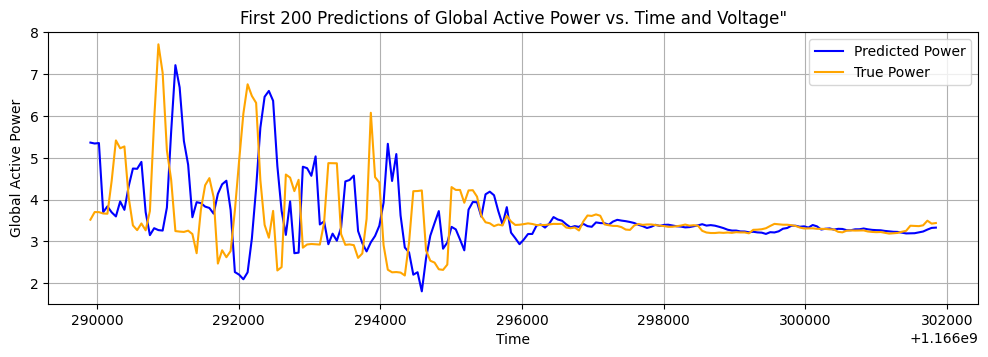

In [24]:
#Plot first 200 data points/predictions for alternative model

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(aligned_tp[:200], aligned_yp_pred[:200], label='Predicted Power', color='blue')
plt.plot(aligned_tp[:200], aligned_ys[:200], label='True Power', color='orange')
plt.title('First 200 Predictions of Global Active Power vs. Time and Voltage"')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid()

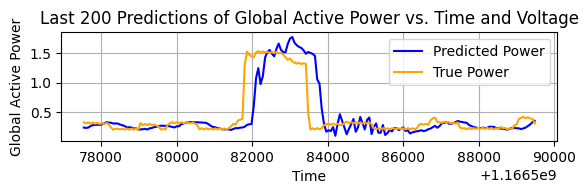

In [25]:
#Plot last 200 data points/predictions for alternative model
plt.subplot(3, 1, 1)
plt.plot(aligned_tp[-200:], aligned_yp_pred[-200:], label='Predicted Power', color='blue')
plt.plot(aligned_tp[-200:], aligned_ys[-200:], label='True Power', color='orange')
plt.title('Last 200 Predictions of Global Active Power vs. Time and Voltage')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid()

In [26]:
#Calculate MSE of predictions for the expanded data

print("MSE is ", mean_squared_error(ys[ph_index:5000+ph_index-1],yp_pred))

MSE is  0.5664015466176773


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: **I. Analysis of model of "Global Active Power vs. Time and Voltage" performance based on the provided plot and the Mean Squared Error (MSE) of 0.5664015466176773**.

**Observations from the Plot:**

- **Fluctuations:** The predicted power exhibits more fluctuations compared to the true power, suggesting that the model might be overfitting to the training data or struggling to capture the finer details of the power consumption variations.

- **Lag:** At certain points, there is a lag in the predicted power compared to the true power. This seems to be due to the model's inability to perfectly predict the timing of power changes.

**Interpretation of MSE:**

- **Magnitude:** An MSE of 0.5664 indicates that, on average, the squared difference between the predicted and true power values is around 0.5664 units.

## II. COMPARISON OF OTHER MODELS WITHOUT VOLTAGE DATA

##Comparison of the MSE values for the models with and without Voltage data:

**MSE comparison with other model**:

MSE with Voltage(mu = 0.9): 0.5664015466176773
MSE without Voltage(mu = 0.9): 0.5227914122681482
Difference in MSE: 0.043610134349529095 (MSE with Voltage - MSE without Voltage)

##Interpretation:

The positive difference in MSE indicates that the model performs slightly worse when using Voltage data. This suggests that:

Voltage data might not be a strong predictor of power consumption in this specific context. It could be that the relationship between Voltage and power consumption is weak or complex, and the model is unable to effectively capture it.

The Voltage data might be adding noise to the model. Including noisy features can hinder the model's ability to learn the true underlying patterns in the data.

The model might be overfitting to the Voltage data. If the model is overly sensitive to the Voltage variations, it could be fitting to the noise in the data rather than the true relationship between power consumption and time.

 **Fluctuations: seen in predicted power** The predicted power exhibits more fluctuations in the model with Voltage and Time copared with the model with Time. This suggests that Voltage may not be the appropriate feature
 compared to the true power, suggesting that the model might be overfitting to the training data or struggling to capture the finer details of the power consumption variations.

- **Lag:** At certain points, there is a lag in the predicted power compared to the true power. This could be due to the model's inability to perfectly predict the timing of power changes.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: **DESCRIPTION OF ALTERNATE MODEL - MOVING AVERAGE BASED MODEL
The moving average based model performs bettwer when compared to he previous Prediction Horizon and Forgetting factor based model. The below are the reasonw why this model might improve the prediction when compared to previous model.

1. Smoothing out fluctuations: A moving average approach helps smooth out short-term fluctuations and highlight longer-term trends in the energy consumption data. This can lead to more stable predictions, especially for monthly forecasts.

2. Capturing seasonal patterns: By using a moving average as the response variable, the model may better capture seasonal and cyclical patterns in energy consumption. This is particularly relevant for monthly predictions, where seasonal factors can significantly impact energy use.

3. Reducing noise: The moving average technique can help filter out noise in the data, allowing the model to focus on underlying trends and patterns. This can be especially beneficial when dealing with real-time or high-frequency energy consumption data.

4. Improved handling of non-linearity: Energy consumption data often exhibits non-linear patterns. A moving average approach may better capture these non-linear relationships compared to linear models.

5. Adaptability: Moving average models adapt to changing patterns in energy consumption over time, which may not be as easily captured by fixed prediction horizon models

In [28]:
#createion of alternative training data

ph = 5  # Prediction horizon in minutes
data_resolution = 1  # Data collection interval in minutes
ph_index = ph // data_resolution

# Limit the number of samples for speed
n_s = min(5000, len(ts))

ts = pd.DataFrame({'Time': df.unix})
ys = pd.DataFrame(df.Global_active_power)

# Calculate moving average
window_size_ma = 30  # Size of the moving average window
ys['MA'] = ys['Global_active_power'].rolling(window=window_size_ma).mean()

# Drop NaN values resulting from the moving average calculation
ts = ts.iloc[window_size_ma-1:]
ys = ys.iloc[window_size_ma-1:]

# Define the size of the moving window for prediction
window_size_pred = 10

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-window_size_pred-1)
yp_pred = np.zeros(n_s-window_size_pred-1)

for i in range(window_size_pred, n_s-1):
    # Get data for the current window
    ts_window = ts.iloc[i-window_size_pred:i]
    ys_window = ys['MA'].iloc[i-window_size_pred:i]

    # Perform linear regression
    model = LinearRegression()
    model.fit(ts_window, ys_window)

    # Predict for the next time step
    next_time = pd.DataFrame({'Time': [ts.iloc[i, 0] + ph]})
    yp = model.predict(next_time)

    # Store predictions
    tp_pred[i-window_size_pred] = next_time['Time'].iloc[0]
    yp_pred[i-window_size_pred] = yp[0]

# Align predicted values with actual values using ph_index
aligned_tp = tp_pred[:n_s-window_size_pred-ph_index-1]
aligned_ys = ys['MA'].values[window_size_pred+ph_index:n_s-1]
aligned_yp_pred = yp_pred[:n_s-window_size_pred-ph_index-1]

# Ensure dimensions match for MSE calculation and plotting
assert len(aligned_tp) == len(aligned_ys) == len(aligned_yp_pred), "Dimension mismatch!"


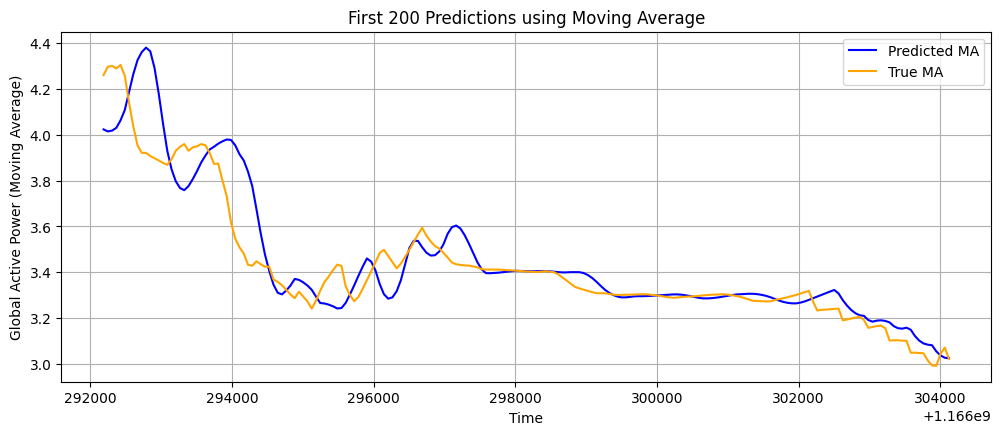

In [29]:
#Plot first 200 data points/predictions for alternative model

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(aligned_tp[:200], aligned_yp_pred[:200], label='Predicted MA', color='blue')
plt.plot(aligned_tp[:200], aligned_ys[:200], label='True MA', color='orange')
plt.title('First 200 Predictions using Moving Average')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Moving Average)')
plt.legend()
plt.grid(True)


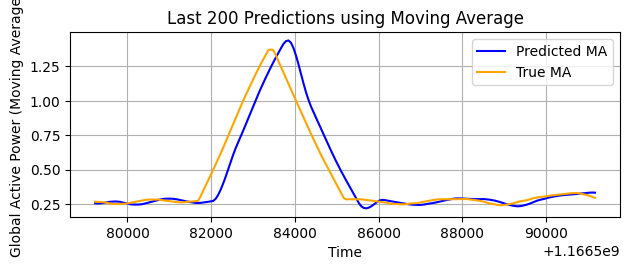

In [30]:
#Plot last 200 data points/predictions for alternative model

plt.subplot(2, 1, 2)
plt.plot(aligned_tp[-200:], aligned_yp_pred[-200:], label='Predicted MA', color='blue')
plt.plot(aligned_tp[-200:], aligned_ys[-200:], label='True MA', color='orange')
plt.title('Last 200 Predictions using Moving Average')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Moving Average)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [31]:
#Calculate MSE of predictions for alternative model

mse = mean_squared_error(aligned_ys, aligned_yp_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.038292915900766084


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: ** I. PERFORMANCE ANALYSIS OF ALTERNATE MODEL - MOVING AVERAGE BASED MODEL
The moving average based model has improved well when compared to the previous Prediction Horizon and Forgetting factor based model

1. BETTER MSE of 0.038292915900766084 The moving average-based model gives a better prediction with MSE which is lesser than the "Prediction Horizon and Forgetting factor" based model for energy consumption.


2. A moving average (MA) model is a common approach for analyzing and forecasting time series data.The model assumes that the current value is a linear combination of past forecast errors.It smooths out short-term fluctuations and highlights longer-term trends in the data.The order q determines how many past error terms are considered.

3. Smoothing out fluctuations: The moving average approach has smoothened out short-term fluctuations and highlight longer-term trends in the energy consumption data

4. Reducing noise: As seen from the chartm the moving average technique helps filter out noise in the data, allowing the model to focus on underlying trends and patterns.

## II. IMPROVISING THE PERFORMANCE FURTHER ##
1.ARMA AND ARIMA MODEL: Moving average models can be combined with autoregressive (AR) models to form more complex ARMA or ARIMA models. ARMA(Autoregressive Moving Average) and ARIMA(Autoregressive Integrated Moving Average) models can capture both autoregressive patterns (dependence on past values) and moving average patterns (dependence on past errors)
This combination allows the models to account for trends, cycles, seasonality, and other non-static types of data

2. VMD(Variation mode decompositon( with deep learning techniques like RNN:
VMD is a signal processing technique that decomposes a signal into different modes:It adaptively decomposes the input signal into a set of band-limited intrinsic mode functions (IMFs).RNNs or other models are then used to predict each decomposed component. The predictions are recombined to form the final forecast This combined approach can lead to higher accuracy and more robust predictions

3. Recurrent Neural Network (RNN):
RNNs are a type of neural network designed to handle sequential data and time series:They incorporate feedback loops to maintain information over time, acting as a form of memory.This allows RNNs to capture temporal dependencies in power consumption data.Long Short-Term Memory (LSTM) networks are a popular type of RNN that can learn long-term dependencies.These models can handle time-series nature of electricity usage data, capturing complex patterns and seasonality in consumption providing high accuracy and performance.



we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.